### define a function to run DiD regression
then run it on the non-imputed and the imputed datasets to see the difference

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def run_did_sensitivity_analysis(csv_file, output_prefix="did_results"):
    """
    Run DID sensitivity analysis across multiple quantile cutoffs.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing panel data
    output_prefix : str
        Prefix for output CSV file (default: "did_results")
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all results from the sensitivity analysis
    """
    
    print("="*80)
    print(f"DID SENSITIVITY ANALYSIS: {csv_file}")
    print("="*80)
    
    # Load the panel data
    panel = pd.read_csv(csv_file)
    panel = panel[panel["year"].isin([2020, 2024])].copy()
    counts_by_buurt = panel.groupby("buurtcode_2022")["year"].nunique()
    valid_buurten = counts_by_buurt[counts_by_buurt == 2].index
    panel = panel[panel["buurtcode_2022"].isin(valid_buurten)].copy()
    
    print(f"Valid neighborhoods: {len(valid_buurten)}")
    
    # Ensure numeric
    num_cols = [
        # Green metrics (for computing treatment)
        "green_coverage_pct_2020","green_coverage_pct_2024",
        "dist_nearest_green_2020","dist_nearest_green_2024",
        # Outcome variables
        "pct_bottom40","pct_top20","pct_low_income","pct_below_120pct_social_min",
        "n_high_education","woz_value","pct_owner_occupied","pct_unoccupied","pct_rental",
        "population_total","pop_age_0_15","pop_age_15_25","pop_age_25_45","pop_age_45_65","pop_age_65_plus",
        "avg_household_size","income_recipient","income_inhabitant","income_household",
        # Control variables
        "supermarkets_1km","food_shops_1km","cafes_1km","cafeterias_1km","restaurants_1km",
        "dist_primary_school","dist_secondary_school","dist_train_station","urbanicity"
    ]

    for c in num_cols:
        if c in panel.columns:
            panel[c] = pd.to_numeric(panel[c], errors="coerce")
    
    # Compute green change metric (once)
    green_change = panel.groupby("buurtcode_2022").apply(
        lambda x: (x.loc[x.year==2024, "green_coverage_pct_2024"].values[0] - 
                x.loc[x.year==2020, "green_coverage_pct_2020"].values[0]) -
                (x.loc[x.year==2024, "dist_nearest_green_2024"].values[0] - 
                x.loc[x.year==2020, "dist_nearest_green_2020"].values[0])
    )

    
    print(f"Green change calculated for {len(green_change)} neighborhoods")
    print(f"Missing values in green_change: {green_change.isna().sum()}")
    
    # Controls and outcomes
    controls = [
        "supermarkets_1km","food_shops_1km","cafes_1km","cafeterias_1km","restaurants_1km",
        "dist_primary_school","dist_secondary_school","dist_train_station","urbanicity"
    ]
    controls = [c for c in controls if c in panel.columns]
    
    outcomes = [
        # Income & inequality
        "pct_bottom40","pct_top20","pct_low_income","pct_below_120pct_social_min",
        "income_household","income_inhabitant",
        # Education & property
        "n_high_education","woz_value",
        # Housing tenure
        "pct_owner_occupied","pct_rental","pct_unoccupied",
        # Demographics
        "pop_age_25_45","pop_age_0_15","pop_age_65_plus","avg_household_size"
    ]
    outcomes = [o for o in outcomes if o in panel.columns]
    
    # Loop over quantile cutoffs
    quantile_cuts = np.arange(0.50, 1.00, 0.05)  # 50% to 95% in 5% steps
    
    all_results = []
    
    for q_cut in quantile_cuts:
        print(f"\n{'='*60}")
        print(f"Quantile cutoff: {q_cut:.0%}")
        print(f"{'='*60}")
        
        # Define treatment based on this cutoff
        threshold = green_change.quantile(q_cut)
        treated_map = (green_change > threshold).astype(int)
        n_treated = treated_map.sum()    
        print(f"Threshold: {threshold:.4f}")
        print(f"Treated count: {n_treated} / {len(treated_map)} ({n_treated/len(treated_map):.1%})")
        
        # Merge treatment into panel
        panel_q = panel.copy()
        panel_q = panel_q.merge(treated_map.rename("treated"), 
                                left_on="buurtcode_2022", right_index=True, how="left")
        panel_q["post"] = (panel_q["year"] == 2024).astype(int)
        panel_q = panel_q.dropna(subset=["treated","post"])
        
        # Run DiD for each outcome
        for y in outcomes:
            rhs = "treated * post"
            if controls:
                rhs += " + " + " + ".join(controls)
            formula = f"{y} ~ {rhs} + C(buurtcode_2022)"
            
            try:
                model = smf.ols(formula=formula, data=panel_q).fit(cov_type="HC1")
                
                coef = model.params.get("treated:post", np.nan)
                se   = model.bse.get("treated:post", np.nan)
                pval = model.pvalues.get("treated:post", np.nan)
                nobs = int(model.nobs)
                
                all_results.append({
                    "quantile_cutoff": q_cut,
                    "threshold": threshold,
                    "n_treated": n_treated,
                    "outcome": y,
                    "did_coef": coef,
                    "se": se,
                    "pvalue": pval,
                    "nobs": nobs
                })
                
            except Exception as e:
                print(f"  Error for {y}: {e}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save detailed results
    output_file = f"{output_prefix}_sensitivity.csv"
    results_df.to_csv(output_file, index=False)
    print(f"\n✓ Saved: {output_file}")
    
    # Print summary by outcome
    print("\n" + "="*80)
    print("SUMMARY: Significance across quantile cutoffs")
    print("="*80)
    
    for outcome in outcomes:
        outcome_df = results_df[results_df["outcome"] == outcome]
        sig_05 = (outcome_df["pvalue"] < 0.05).sum()
        sig_01 = (outcome_df["pvalue"] < 0.01).sum()
        
        print(f"\n{outcome}:")
        print(f"  Significant at p<0.05: {sig_05}/{len(outcome_df)} cutoffs")
        print(f"  Significant at p<0.01: {sig_01}/{len(outcome_df)} cutoffs")
        print(f"  Coefficient range: [{outcome_df['did_coef'].min():.4f}, {outcome_df['did_coef'].max():.4f}]")
    
    print("\n" + "="*80)
    print("LOWEST P-VALUES FOR EACH OUTCOME")
    print("="*80)
    
    for outcome in outcomes:
        outcome_df = results_df[results_df["outcome"] == outcome].copy()
        
        # Find row with lowest p-value
        min_pval_idx = outcome_df["pvalue"].idxmin()
        min_row = outcome_df.loc[min_pval_idx]
        
        print(f"\n{outcome}:")
        print(f"  Lowest p-value: {min_row['pvalue']:.6f}")
        print(f"  Found at quantile cutoff: {min_row['quantile_cutoff']:.0%}")
        print(f"  DiD coefficient: {min_row['did_coef']:.4f}")
        print(f"  Standard error: {min_row['se']:.4f}")
        print(f"  Threshold: {min_row['threshold']:.4f}")
        print(f"  N treated: {int(min_row['n_treated'])}")
        
        # Also show if significant
        if min_row['pvalue'] < 0.001:
            sig_level = "***"
        elif min_row['pvalue'] < 0.01:
            sig_level = "**"
        elif min_row['pvalue'] < 0.05:
            sig_level = "*"
        else:
            sig_level = "n.s."
        print(f"  Significance: {sig_level}")
    
    return results_df


# Run analysis on both datasets
print("\n" + "#"*80)
print("# ANALYSIS 1: IMPUTED DATA")
print("#"*80 + "\n")
results_imputed = run_did_sensitivity_analysis(
    "../data/merged_buurt_panel_data_imputed.csv",
    output_prefix="../results/did_results_imputed"
)

print("\n" + "#"*80)
print("# ANALYSIS 2: NON-IMPUTED DATA")
print("#"*80 + "\n")
results_non_imputed = run_did_sensitivity_analysis(
    "../data/non_imputed_merged_buurt_panel_data.csv",
    output_prefix="../results/did_results_non_imputed"
)

# Add this code after you've run the analysis on the imputed data
print("\n" + "#"*80)
print("# FINAL SUMMARY OF BEST RESULTS (FROM IMPUTED DATA)")
print("#"*80 + "\n")

summary_list = []
outcomes = results_imputed["outcome"].unique()

for outcome in outcomes:
    # Find the row with the minimum p-value for this outcome
    best_row = results_imputed.loc[results_imputed[results_imputed['outcome'] == outcome]['pvalue'].idxmin()]
    summary_list.append(best_row)

summary_df = pd.DataFrame(summary_list)

# Select and rename columns for a clean presentation
summary_df = summary_df[[
    "outcome", "did_coef", "pvalue", "quantile_cutoff", "n_treated"
]].rename(columns={
    "outcome": "Gentrification Indicator",
    "did_coef": "Effect of Greening",
    "pvalue": "P-Value",
    "quantile_cutoff": "Greening Threshold",
    "n_treated": "Num. Greened Buurten"
})

print(summary_df.to_string(index=False))

# Optional: Compare results between datasets
#print("\n" + "="*80)
#print("COMPARISON: Imputed vs Non-Imputed")
#print("="*80)

#for outcome in results_imputed["outcome"].unique():
#    imp_df = results_imputed[results_imputed["outcome"] == outcome]
#    non_imp_df = results_non_imputed[results_non_imputed["outcome"] == outcome]
    
    # Find best p-value for each
#    imp_best = imp_df.loc[imp_df["pvalue"].idxmin()]
 #   non_imp_best = non_imp_df.loc[non_imp_df["pvalue"].idxmin()]
 #   
 #   print(f"\n{outcome}:")
 #   print(f"  Imputed:     p={imp_best['pvalue']:.6f}, coef={imp_best['did_coef']:.4f} (n={imp_best['nobs']:.0f})")
  #  print(f"  Non-imputed: p={non_imp_best['pvalue']:.6f}, coef={non_imp_best['did_coef']:.4f} (n={non_imp_best['nobs']:.0f})")


################################################################################
# ANALYSIS 1: IMPUTED DATA
################################################################################

DID SENSITIVITY ANALYSIS: merged_buurt_panel_data_imputed.csv
Valid neighborhoods: 439


C:\Users\tomma\AppData\Local\Temp\ipykernel_29060\2601794597.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  green_change = panel.groupby("buurtcode_2022").apply(


Green change calculated for 439 neighborhoods
Missing values in green_change: 0

Quantile cutoff: 50%
Threshold: 0.1700
Treated count: 219 / 439 (49.9%)

Quantile cutoff: 55%
Threshold: 0.4600
Treated count: 198 / 439 (45.1%)

Quantile cutoff: 60%
Threshold: 1.3320
Treated count: 176 / 439 (40.1%)

Quantile cutoff: 65%
Threshold: 2.8720
Treated count: 154 / 439 (35.1%)

Quantile cutoff: 70%
Threshold: 7.6820
Treated count: 132 / 439 (30.1%)

Quantile cutoff: 75%
Threshold: 14.2600
Treated count: 109 / 439 (24.8%)

Quantile cutoff: 80%
Threshold: 41.9600
Treated count: 88 / 439 (20.0%)

Quantile cutoff: 85%
Threshold: 71.8480
Treated count: 66 / 439 (15.0%)

Quantile cutoff: 90%
Threshold: 121.7580
Treated count: 44 / 439 (10.0%)

Quantile cutoff: 95%
Threshold: 230.7930
Treated count: 22 / 439 (5.0%)

✓ Saved: did_results_imputed_sensitivity.csv

SUMMARY: Significance across quantile cutoffs

pct_bottom40:
  Significant at p<0.05: 2/10 cutoffs
  Significant at p<0.01: 0/10 cutoffs
  Co

C:\Users\tomma\AppData\Local\Temp\ipykernel_29060\2601794597.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  green_change = panel.groupby("buurtcode_2022").apply(


Green change calculated for 439 neighborhoods
Missing values in green_change: 0

Quantile cutoff: 50%
Threshold: 0.1700
Treated count: 219 / 439 (49.9%)

Quantile cutoff: 55%
Threshold: 0.4600
Treated count: 198 / 439 (45.1%)

Quantile cutoff: 60%
Threshold: 1.3320
Treated count: 176 / 439 (40.1%)

Quantile cutoff: 65%
Threshold: 2.8720
Treated count: 154 / 439 (35.1%)

Quantile cutoff: 70%
Threshold: 7.6820
Treated count: 132 / 439 (30.1%)

Quantile cutoff: 75%
Threshold: 14.2600
Treated count: 109 / 439 (24.8%)

Quantile cutoff: 80%
Threshold: 41.9600
Treated count: 88 / 439 (20.0%)

Quantile cutoff: 85%
Threshold: 71.8480
Treated count: 66 / 439 (15.0%)

Quantile cutoff: 90%
Threshold: 121.7580
Treated count: 44 / 439 (10.0%)

Quantile cutoff: 95%
Threshold: 230.7930
Treated count: 22 / 439 (5.0%)

✓ Saved: did_results_non_imputed_sensitivity.csv

SUMMARY: Significance across quantile cutoffs

pct_bottom40:
  Significant at p<0.05: 0/10 cutoffs
  Significant at p<0.01: 0/10 cutoffs


In [ ]:
# Generate detailed regression output for key results
print("\n" + "#"*80)
print("# DETAILED REGRESSION TABLES FOR KEY RESULTS")
print("#"*80 + "\n")

# Load the imputed data
panel = pd.read_csv("../data/merged_buurt_panel_data_imputed.csv")
panel = panel[panel["year"].isin([2020, 2024])].copy()
counts_by_buurt = panel.groupby("buurtcode_2022")["year"].nunique()
valid_buurten = counts_by_buurt[counts_by_buurt == 2].index
panel = panel[panel["buurtcode_2022"].isin(valid_buurten)].copy()

# Ensure numeric
num_cols = [
    # Green metrics (for computing treatment)
    "green_coverage_pct_2020","green_coverage_pct_2024",
    "dist_nearest_green_2020","dist_nearest_green_2024",
    # Outcome variables
    "pct_bottom40","pct_top20","pct_low_income","pct_below_120pct_social_min",
    "n_high_education","woz_value","pct_owner_occupied","pct_unoccupied","pct_rental",
    "population_total","pop_age_0_15","pop_age_15_25","pop_age_25_45","pop_age_45_65","pop_age_65_plus",
    "avg_household_size","income_recipient","income_inhabitant","income_household",
    # Control variables
    "supermarkets_1km","food_shops_1km","cafes_1km","cafeterias_1km","restaurants_1km",
    "dist_primary_school","dist_secondary_school","dist_train_station","urbanicity"
]
for c in num_cols:
    if c in panel.columns:
        panel[c] = pd.to_numeric(panel[c], errors="coerce")

# Compute green change metric
green_change = panel.groupby("buurtcode_2022").apply(
    lambda x: (x.loc[x.year==2024, "green_coverage_pct_2024"].values[0] - 
            x.loc[x.year==2020, "green_coverage_pct_2020"].values[0]) -
            (x.loc[x.year==2024, "dist_nearest_green_2024"].values[0] - 
            x.loc[x.year==2020, "dist_nearest_green_2020"].values[0])
)

# Controls
controls = [
    "supermarkets_1km","food_shops_1km","cafes_1km","cafeterias_1km","restaurants_1km",
    "dist_primary_school","dist_secondary_school","dist_train_station","urbanicity"
]
controls = [c for c in controls if c in panel.columns]

# ============================================================================
# KEY RESULT 1: pop_age_0_15 at 65% cutoff (FAMILY ATTRACTION STORY)
# ============================================================================
print("="*80)
print("MODEL 1: pop_age_0_15 (Young Children) at 65% Quantile Cutoff")
print("="*80 + "\n")

q_cut = 0.65
threshold = green_change.quantile(q_cut)
treated_map = (green_change > threshold).astype(int)

panel_q = panel.copy()
panel_q = panel_q.merge(treated_map.rename("treated"), 
                        left_on="buurtcode_2022", right_index=True, how="left")
panel_q["post"] = (panel_q["year"] == 2024).astype(int)
panel_q = panel_q.dropna(subset=["treated","post"])

rhs = "treated * post"
if controls:
    rhs += " + " + " + ".join(controls)
formula = f"pop_age_0_15 ~ {rhs} + C(buurtcode_2022)"

model_1 = smf.ols(formula=formula, data=panel_q).fit(cov_type="HC1")
print(model_1.summary())

print(f"\n{'='*60}")
print(f"Treatment threshold: {threshold:.4f}")
print(f"Number of treated neighborhoods: {treated_map.sum()}")
print(f"{'='*60}\n")

# ============================================================================
# KEY RESULT 2: pct_bottom40 at 90% cutoff (DISPLACEMENT PRESSURE STORY)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: pct_bottom40 (Low-Income Households) at 90% Quantile Cutoff")
print("="*80 + "\n")

q_cut = 0.90
threshold = green_change.quantile(q_cut)
treated_map = (green_change > threshold).astype(int)

panel_q = panel.copy()
panel_q = panel_q.merge(treated_map.rename("treated"), 
                        left_on="buurtcode_2022", right_index=True, how="left")
panel_q["post"] = (panel_q["year"] == 2024).astype(int)
panel_q = panel_q.dropna(subset=["treated","post"])

rhs = "treated * post"
if controls:
    rhs += " + " + " + ".join(controls)
formula = f"pct_bottom40 ~ {rhs} + C(buurtcode_2022)"

model_2 = smf.ols(formula=formula, data=panel_q).fit(cov_type="HC1")
print(model_2.summary())

print(f"\n{'='*60}")
print(f"Treatment threshold: {threshold:.4f}")
print(f"Number of treated neighborhoods: {treated_map.sum()}")
print(f"{'='*60}\n")

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "#"*80)
print("# INTERPRETATION")
print("#"*80 + "\n")

print("MODEL 1 - FAMILY ATTRACTION STORY (pop_age_0_15 at 65% cutoff):")
print(f"  DiD Coefficient: {model_1.params.get('treated:post', np.nan):.4f}")
print(f"  P-value: {model_1.pvalues.get('treated:post', np.nan):.6f}")
print(f"  Interpretation: Moderately greened neighborhoods experienced a change of")
print(f"                  {model_1.params.get('treated:post', np.nan):.2f} children (age 0-15).")
print(f"                  This suggests families are attracted to improved green spaces.\n")

print("MODEL 2 - DISPLACEMENT PRESSURE STORY (pct_bottom40 at 90% cutoff):")
print(f"  DiD Coefficient: {model_2.params.get('treated:post', np.nan):.4f}")
print(f"  P-value: {model_2.pvalues.get('treated:post', np.nan):.6f}")
print(f"  Interpretation: Heavily greened neighborhoods experienced a {model_2.params.get('treated:post', np.nan):.2f}")
print(f"                  percentage point change in low-income households.")
print(f"                  This suggests displacement pressure in the most transformed areas.\n")


################################################################################
# DETAILED REGRESSION TABLES FOR KEY RESULTS
################################################################################



C:\Users\tomma\AppData\Local\Temp\ipykernel_29060\2625817139.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  green_change = panel.groupby("buurtcode_2022").apply(


MODEL 1: pop_age_0_15 (Young Children) at 65% Quantile Cutoff



c:\Users\tomma\Documents\Bachelor's AI\Honours Programme\Planetary Health & The Symbiotic City\green gentrification\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 450, but rank is 449
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:           pop_age_0_15   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 3.076e+04
Date:                Fri, 10 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:59:37   Log-Likelihood:                -4124.8
No. Observations:                 878   AIC:                             9150.
Df Residuals:                     428   BIC:                         1.130e+04
Df Model:                         449                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\tomma\Documents\Bachelor's AI\Honours Programme\Planetary Health & The Symbiotic City\green gentrification\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 450, but rank is 449
  warnings.warn('covariance of constraints does not have full '


✓ Saved: coefficient_plots_both_stories.png


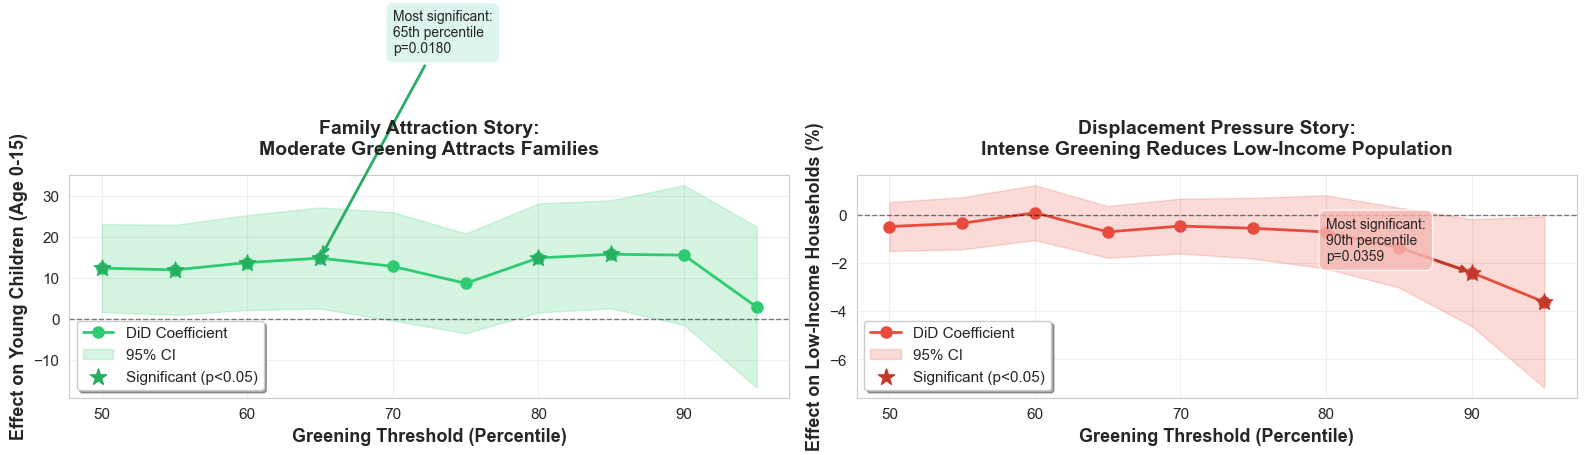

✓ Saved: coefficient_plot_family_attraction.png


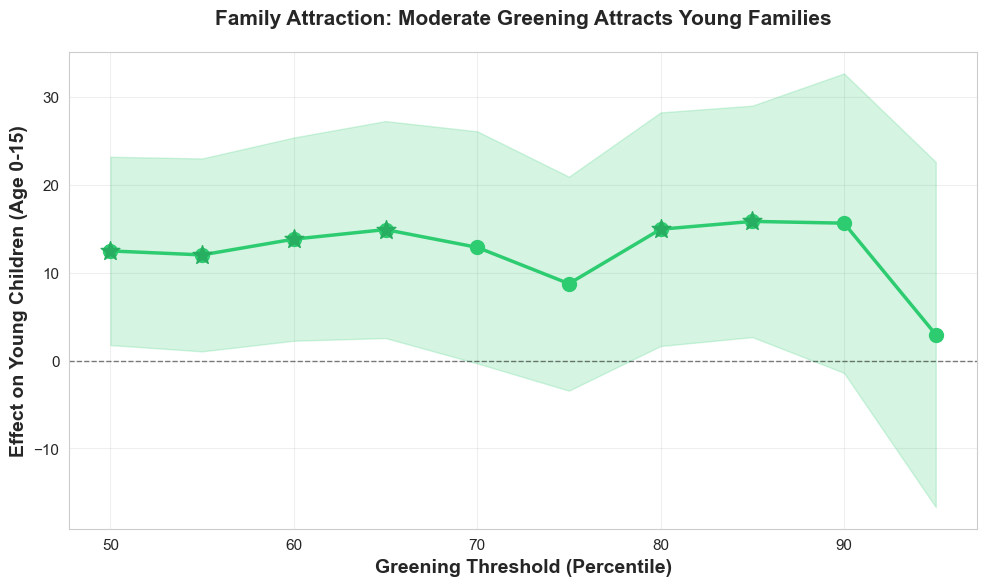

✓ Saved: coefficient_plot_displacement.png


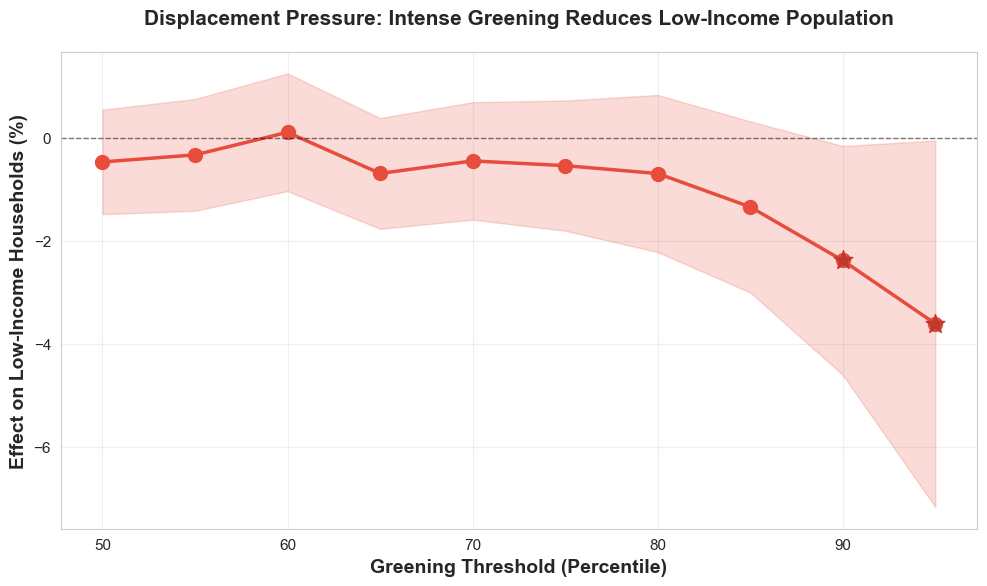


VISUALIZATION SUMMARY
✓ Created combined plot with both stories
✓ Created individual high-resolution plots
✓ All plots show coefficient trajectories with 95% confidence intervals
✓ Significant results (p<0.05) are marked with stars
✓ Most significant points are annotated


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Load the sensitivity analysis results
results_df = pd.read_csv("../results/did_results_imputed_sensitivity.csv")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ============================================================================
# PLOT 1: FAMILY ATTRACTION STORY (pop_age_0_15)
# ============================================================================

# Filter data for pop_age_0_15
pop_data = results_df[results_df["outcome"] == "pop_age_0_15"].copy()

# Calculate 95% confidence intervals
pop_data["ci_lower"] = pop_data["did_coef"] - 1.96 * pop_data["se"]
pop_data["ci_upper"] = pop_data["did_coef"] + 1.96 * pop_data["se"]

# Convert quantile to percentage for better labels
pop_data["threshold_pct"] = (pop_data["quantile_cutoff"] * 100).round(0).astype(int)

# Create the plot
ax1.plot(pop_data["threshold_pct"], pop_data["did_coef"], 
         marker='o', linewidth=2, markersize=8, color='#2ecc71', label='DiD Coefficient')

# Add confidence interval as shaded area
ax1.fill_between(pop_data["threshold_pct"], 
                 pop_data["ci_lower"], 
                 pop_data["ci_upper"], 
                 alpha=0.2, color='#2ecc71', label='95% CI')

# Add horizontal line at zero
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Highlight significant points (p < 0.05)
sig_points = pop_data[pop_data["pvalue"] < 0.05]
ax1.scatter(sig_points["threshold_pct"], sig_points["did_coef"], 
           s=150, color='#27ae60', marker='*', zorder=5, 
           label='Significant (p<0.05)')

# Labels and title
ax1.set_xlabel("Greening Threshold (Percentile)", fontsize=13, fontweight='bold')
ax1.set_ylabel("Effect on Young Children (Age 0-15)", fontsize=13, fontweight='bold')
ax1.set_title("Family Attraction Story:\nModerate Greening Attracts Families", 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', frameon=True, shadow=True)
ax1.grid(True, alpha=0.3)

# Add annotation for most significant point
best_idx = pop_data["pvalue"].idxmin()
best_point = pop_data.loc[best_idx]
ax1.annotate(f'Most significant:\n{best_point["threshold_pct"]:.0f}th percentile\np={best_point["pvalue"]:.4f}',
            xy=(best_point["threshold_pct"], best_point["did_coef"]),
            xytext=(best_point["threshold_pct"]+5, best_point["did_coef"]+50),
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='#d5f4e6', alpha=0.8))

# ============================================================================
# PLOT 2: DISPLACEMENT PRESSURE STORY (pct_bottom40)
# ============================================================================

# Filter data for pct_bottom40
income_data = results_df[results_df["outcome"] == "pct_bottom40"].copy()

# Calculate 95% confidence intervals
income_data["ci_lower"] = income_data["did_coef"] - 1.96 * income_data["se"]
income_data["ci_upper"] = income_data["did_coef"] + 1.96 * income_data["se"]

# Convert quantile to percentage
income_data["threshold_pct"] = (income_data["quantile_cutoff"] * 100).round(0).astype(int)

# Create the plot
ax2.plot(income_data["threshold_pct"], income_data["did_coef"], 
         marker='o', linewidth=2, markersize=8, color='#e74c3c', label='DiD Coefficient')

# Add confidence interval as shaded area
ax2.fill_between(income_data["threshold_pct"], 
                 income_data["ci_lower"], 
                 income_data["ci_upper"], 
                 alpha=0.2, color='#e74c3c', label='95% CI')

# Add horizontal line at zero
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Highlight significant points (p < 0.05)
sig_points = income_data[income_data["pvalue"] < 0.05]
ax2.scatter(sig_points["threshold_pct"], sig_points["did_coef"], 
           s=150, color='#c0392b', marker='*', zorder=5, 
           label='Significant (p<0.05)')

# Labels and title
ax2.set_xlabel("Greening Threshold (Percentile)", fontsize=13, fontweight='bold')
ax2.set_ylabel("Effect on Low-Income Households (%)", fontsize=13, fontweight='bold')
ax2.set_title("Displacement Pressure Story:\nIntense Greening Reduces Low-Income Population", 
             fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='best', frameon=True, shadow=True)
ax2.grid(True, alpha=0.3)

# Add annotation for most significant point
best_idx = income_data["pvalue"].idxmin()
best_point = income_data.loc[best_idx]
ax2.annotate(f'Most significant:\n{best_point["threshold_pct"]:.0f}th percentile\np={best_point["pvalue"]:.4f}',
            xy=(best_point["threshold_pct"], best_point["did_coef"]),
            xytext=(best_point["threshold_pct"]-10, best_point["did_coef"]+0.5),
            arrowprops=dict(arrowstyle='->', color='#c0392b', lw=2),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='#f5b7b1', alpha=0.8))

# Adjust layout and save
plt.tight_layout()
plt.savefig("../results/coefficient_plots_both_stories.png", dpi=300, bbox_inches='tight')
print("✓ Saved: coefficient_plots_both_stories.png")
plt.show()

# ============================================================================
# BONUS: Create individual high-res versions
# ============================================================================

# Individual plot 1: Family Attraction
fig1, ax = plt.subplots(figsize=(10, 6))
pop_data = results_df[results_df["outcome"] == "pop_age_0_15"].copy()
pop_data["ci_lower"] = pop_data["did_coef"] - 1.96 * pop_data["se"]
pop_data["ci_upper"] = pop_data["did_coef"] + 1.96 * pop_data["se"]
pop_data["threshold_pct"] = (pop_data["quantile_cutoff"] * 100).round(0).astype(int)

ax.plot(pop_data["threshold_pct"], pop_data["did_coef"], 
        marker='o', linewidth=2.5, markersize=10, color='#2ecc71')
ax.fill_between(pop_data["threshold_pct"], pop_data["ci_lower"], pop_data["ci_upper"], 
                alpha=0.2, color='#2ecc71')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

sig_points = pop_data[pop_data["pvalue"] < 0.05]
ax.scatter(sig_points["threshold_pct"], sig_points["did_coef"], 
          s=200, color='#27ae60', marker='*', zorder=5)

ax.set_xlabel("Greening Threshold (Percentile)", fontsize=14, fontweight='bold')
ax.set_ylabel("Effect on Young Children (Age 0-15)", fontsize=14, fontweight='bold')
ax.set_title("Family Attraction: Moderate Greening Attracts Young Families", 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/coefficient_plot_family_attraction.png", dpi=300, bbox_inches='tight')
print("✓ Saved: coefficient_plot_family_attraction.png")
plt.show()

# Individual plot 2: Displacement Pressure
fig2, ax = plt.subplots(figsize=(10, 6))
income_data = results_df[results_df["outcome"] == "pct_bottom40"].copy()
income_data["ci_lower"] = income_data["did_coef"] - 1.96 * income_data["se"]
income_data["ci_upper"] = income_data["did_coef"] + 1.96 * income_data["se"]
income_data["threshold_pct"] = (income_data["quantile_cutoff"] * 100).round(0).astype(int)

ax.plot(income_data["threshold_pct"], income_data["did_coef"], 
        marker='o', linewidth=2.5, markersize=10, color='#e74c3c')
ax.fill_between(income_data["threshold_pct"], income_data["ci_lower"], income_data["ci_upper"], 
                alpha=0.2, color='#e74c3c')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

sig_points = income_data[income_data["pvalue"] < 0.05]
ax.scatter(sig_points["threshold_pct"], sig_points["did_coef"], 
          s=200, color='#c0392b', marker='*', zorder=5)

ax.set_xlabel("Greening Threshold (Percentile)", fontsize=14, fontweight='bold')
ax.set_ylabel("Effect on Low-Income Households (%)", fontsize=14, fontweight='bold')
ax.set_title("Displacement Pressure: Intense Greening Reduces Low-Income Population", 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/coefficient_plot_displacement.png", dpi=300, bbox_inches='tight')
print("✓ Saved: coefficient_plot_displacement.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("✓ Created combined plot with both stories")
print("✓ Created individual high-resolution plots")
print("✓ All plots show coefficient trajectories with 95% confidence intervals")
print("✓ Significant results (p<0.05) are marked with stars")
print("✓ Most significant points are annotated")